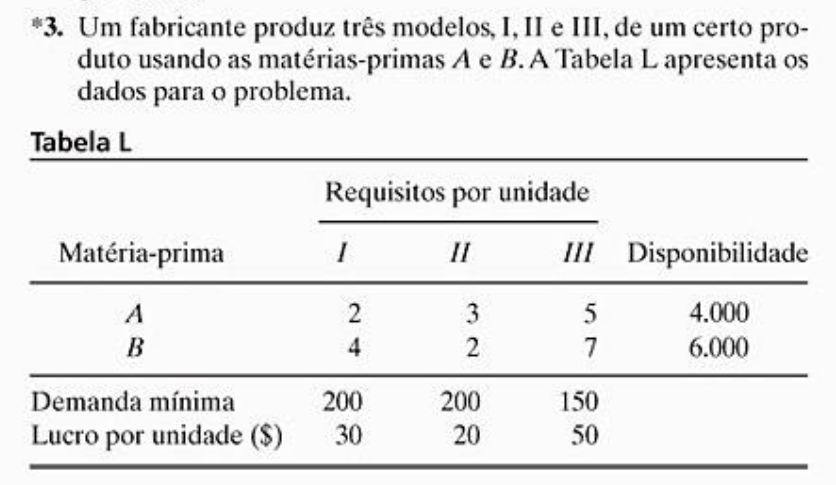

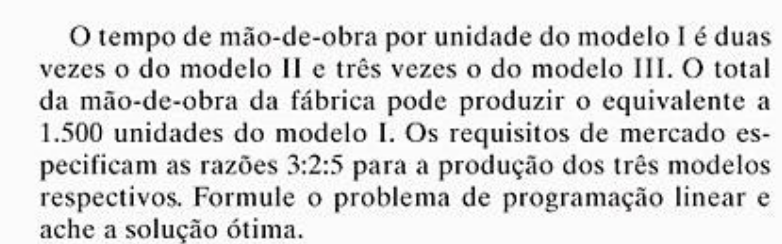

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Otima_3Modelos')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Identificadores
modelos = [1, 2, 3]
materias_primas = ['A', 'B']

# Dados financeiros e de demanda
lucro_unitario = {1: 30, 2: 20, 3: 50}
demanda_minima = {1: 200, 2: 200, 3: 150}

# Dados de matéria-prima
disponibilidade_mp = {'A': 4000, 'B': 6000}
# Estrutura: requisitos_mp[modelo][materia_prima]
requisitos_mp = {
    1: {'A': 2, 'B': 4},
    2: {'A': 3, 'B': 2},
    3: {'A': 5, 'B': 7}
}

# Dados de mão-de-obra (relativos ao Modelo I)
capacidade_total_mao_de_obra = 1500 # em unidades equivalentes do Modelo I
# Tempo M1 = 2 * Tempo M2  => Tempo M2 = 0.5 * Tempo M1
# Tempo M1 = 3 * Tempo M3  => Tempo M3 = (1/3) * Tempo M1
uso_mao_de_obra = {1: 1.0, 2: 0.5, 3: 1/3}

In [4]:
# 1. Variáveis de Decisão
# Número de unidades a serem produzidas de cada modelo
num_unidades = model.continuous_var_dict(modelos, name='P')


# 2. Função Objetivo
# Maximizar o lucro total
expressao_lucro = (lucro_unitario[m] * num_unidades[m] for m in modelos)
lucro_total = model.sum(expressao_lucro)
model.maximize(lucro_total)


# 3. Restrições

# Restrições de Matéria-Prima
for mp in materias_primas:
    expressao_uso_mp = (requisitos_mp[m][mp] * num_unidades[m] for m in modelos)
    soma_uso_mp = model.sum(expressao_uso_mp)
    restr_mp_logica = soma_uso_mp <= disponibilidade_mp[mp]
    model.add_constraint(restr_mp_logica, ctname=f'limite_mp_{mp}')

# Restrição de Mão-de-Obra
expressao_uso_mao_obra = (uso_mao_de_obra[m] * num_unidades[m] for m in modelos)
soma_uso_mao_obra = model.sum(expressao_uso_mao_obra)
restr_mao_obra_logica = soma_uso_mao_obra <= capacidade_total_mao_de_obra
model.add_constraint(restr_mao_obra_logica, ctname='limite_mao_de_obra')

# Restrições de Demanda Mínima
for m in modelos:
    restr_demanda_logica = num_unidades[m] >= demanda_minima[m]
    model.add_constraint(restr_demanda_logica, ctname=f'demanda_min_{m}')

# Restrições da Razão de Mercado (3:2:5)
# P1/P2 = 3/2  =>  2*P1 = 3*P2  =>  2*P1 - 3*P2 = 0
restr_ratio1_logica = 2 * num_unidades[1] - 3 * num_unidades[2] == 0
model.add_constraint(restr_ratio1_logica, ctname='ratio_1_2')

# P2/P3 = 2/5  =>  5*P2 = 2*P3  =>  5*P2 - 2*P3 = 0
restr_ratio2_logica = 5 * num_unidades[2] - 2 * num_unidades[3] == 0
model.add_constraint(restr_ratio2_logica, ctname='ratio_2_3')

docplex.mp.LinearConstraint[ratio_2_3](5P_2-2P_3,EQ,0)

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
print(solucao)
lucro_maximo = lucro_total.solution_value
print(f"\nO lucro total máximo é de ${lucro_maximo:,.2f}.")


--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 6 rows and 1 columns.
Aggregator did 2 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

------ SOLUÇÃO ÓTIMA ------

solution for: Producao_Otima_3Modelos
objective: 41081.1
status: OPTIMAL_SOLUTION(2)
P_1=324.324
P_2=216.216
P_3=540.541


O lucro total máximo é de $41,081.08.
